In [66]:
import numpy as np
import pydicom
import pandas as pd
from datetime import datetime as dt
from glob import glob

import subtle.subtle_io as suio
import skimage.morphology as morph
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams["figure.figsize"] = (10, 8)

def get_dcm(dirpath_dcm):
    return pydicom.dcmread([fpath for fpath in glob('{}/*.dcm'.format(dirpath_dcm))][0])

def get_time_str(time_str):
    return time_str.split('.')[0]

def get_diff_in_secs(time1, time2):
    dt_format = '%H%M%S'
    
    t1 = dt.strptime(time1, dt_format)
    t2 = dt.strptime(time2, dt_format)
    
    return (t2-t1).seconds

def get_time_diff(path_zero, path_low, path_full):
    dcm_zero = get_dcm(path_zero)
    dcm_low = get_dcm(path_low)
    dcm_full = get_dcm(path_full)
    
    zero_dict = get_time_str(dcm_zero.AcquisitionTime)
    low_dict = get_time_str(dcm_low.AcquisitionTime)
    full_dict = get_time_str(dcm_full.AcquisitionTime)
    
    return {
        'low_zero': get_diff_in_secs(zero_dict, low_dict),
        'full_low': get_diff_in_secs(low_dict, full_dict)
    }

def compile_time_info(dirpath_dcm):
    paths = suio.get_dicom_dirs(dirpath_dcm)
    if len(paths) < 3:
        return None
    return get_time_diff(paths[0], paths[1], paths[2]) 

def get_mean_acqtime(dirpath_dcms):
    diff_dict = {}
    for dirpath_dcm in dirpath_dcms:
        case_num = dirpath_dcm.split('/')[-1]
        time_info = compile_time_info(dirpath_dcm)
        if time_info is not None:
            diff_dict[case_num] = time_info

    df_diff = pd.DataFrame(diff_dict).T
    return {
        'mean': dict(df_diff.mean()),
        'std': dict(df_diff.std())
    }

def show_img(img, title='', axis=False, vmin=None, vmax=None, colorbar=False, fname=None):
    plt.clf()
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)
    
    if fname is not None:
        plt.savefig(fname)

def show_gad_comparison(img_pre, img_low, img_post):
    fig = plt.figure(figsize=(18, 12))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title='Pre contrast')

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title='10% dosage')

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title='Full dosage')

    plt.show()

def get_enhancement(img1, img2):
    diff = img2-img1
    diff = np.interp(diff, (diff.min(), diff.max()), (0, 1))
    diff = diff > 0.1
    return diff

def get_mean_enhancement(fpath_h5, h5_key='data_mask'):
    study_data = suio.load_h5_file(fpath_h5, h5_key=h5_key)
    zero_vol = study_data[:, 0, ...]
    low_vol = study_data[:, 1, ...]

    diff_vol = low_vol - zero_vol
    diff_vol[diff_vol < 0] = 0
    diff_vol = diff_vol > 0.15
    
    enh_mask = morph.remove_small_objects(diff_vol)
    enh_mask = morph.binary_erosion(enh_mask, selem=morph.cube(3))
    enh_mask = morph.binary_dilation(enh_mask)
    
    enh_img = low_vol * enh_mask
    
    case_num = fpath_h5.split('/')[-1].replace('.h5', '')
    pidx = enh_img.shape[0] // 2
    show_img(enh_img[pidx], fname='enh_imgs/{}.png'.format(case_num))
    
    return enh_img[np.nonzero(enh_img)].max()

<Figure size 720x576 with 0 Axes>

In [59]:
base_path = '/home/srivathsa/projects/studies/gad/tiantan/data'
dirpath_dcms = sorted(glob('{}/NO*'.format(base_path)))
print(get_mean_acqtime(dirpath_dcms))

{'mean': {'full_low': 177.7625, 'low_zero': 364.2}, 'std': {'full_low': 20.656469088154285, 'low_zero': 66.71408861892041}}


In [44]:
base_path = '/home/srivathsa/projects/studies/gad/hoag/data'
dirpath_dcms = [f for f in sorted(glob('{}/*'.format(base_path))) if 'Id' in f]
print(get_mean_acqtime(dirpath_dcms))

{'mean': {'full_low': 676.7741935483871, 'low_zero': 1403.0}, 'std': {'full_low': 209.12878164381863, 'low_zero': 321.7739372085108}}


In [45]:
base_path = '/home/srivathsa/projects/studies/gad/stanford/data'
dirpath_dcms = [f for f in sorted(glob('{}/*'.format(base_path))) if 'Patient' in f]
print(get_mean_acqtime(dirpath_dcms))

{'mean': {'full_low': 576.3589743589744, 'low_zero': 736.9487179487179}, 'std': {'full_low': 109.60490941258713, 'low_zero': 187.349651821899}}


In [46]:
base_path = '/home/srivathsa/projects/studies/gad/sford_siemens/data'
dirpath_dcms = [f for f in sorted(glob('{}/*'.format(base_path))) if 'Patient' in f]
print(get_mean_acqtime(dirpath_dcms))

{'mean': {'full_low': 564.1481481481482, 'low_zero': 738.925925925926}, 'std': {'full_low': 32.858324906627786, 'low_zero': 144.19002577419678}}


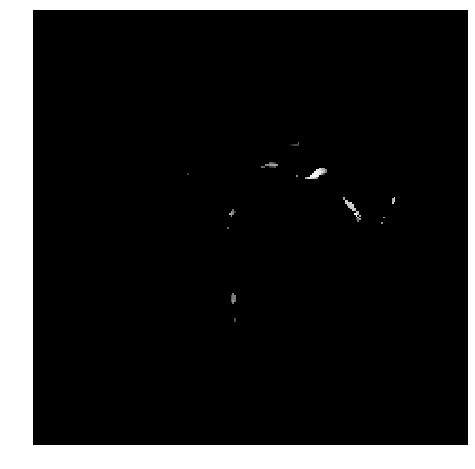

In [68]:
pp_base = '/home/srivathsa/projects/studies/gad/tiantan/preprocess/data'
dcm_base = '/home/srivathsa/projects/studies/gad/tiantan/data'

data_points = []

dfiles = [f for f in glob('{}/*.h5'.format(pp_base))]

for fpath_h5 in tqdm(dfiles, total=len(dfiles)):
    case_num = fpath_h5.split('/')[-1].replace('.h5', '')
    dcm_path = '{}/{}'.format(dcm_base, case_num)
    acq_dict = compile_time_info(dcm_path)
    mean_en = get_mean_enhancement(fpath_h5)
    data_points.append((acq_dict['low_zero'], mean_en))
    #print(case_num, acq_dict['low_zero'], mean_en)

Text(0, 0.5, 'Mean enhancement value')

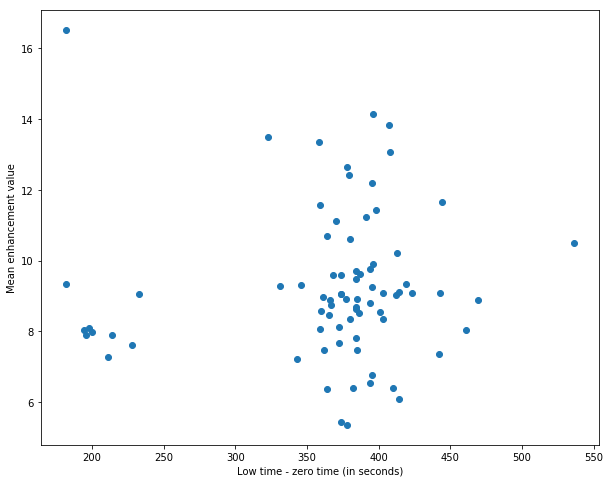

In [69]:
data_points = np.array(data_points)
plt.scatter(data_points[:, 0], data_points[:, 1])
plt.xlabel('Low time - zero time (in seconds)')
plt.ylabel('Mean enhancement value')